In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='2'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [22]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=2,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcnnew-full-supervised-split2/",
    project_name="breakfast-split-2",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 2, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcnnew-full-supervised-split2/', 'project_name': 'breakfast-split-2', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split2.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split2.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1261
Number of videos not found in train fold is 0
Number of videos logged in test fold is 451
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", allow_pickle=True).item()
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [11]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[cur_class]
    mean_class = mean_class * 10
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [12]:
prob_video_each_segment_dict = {}

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele.item())

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [14]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [15]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [16]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele + ".txt"]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [17]:

def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [19]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [20]:
def get_single_random(labels_all, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((labels_all.shape[0], labels_all.shape[1]), dtype=torch.long, device=labels_all.device) * (-100)
    for iter_num, labels in enumerate(labels_all):
        cur_vidid = video_ids[iter_num]
        frame_idx_tensor = torch.from_numpy(np.array(loaded_vidid_selected_frames[cur_vidid + ".txt"]))
        boundary_target_tensor[iter_num, frame_idx_tensor] = labels[frame_idx_tensor]

    return boundary_target_tensor

In [21]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcnnew-full-supervised/'

In [23]:
initialize_epoch = 15
expectation_cal_gap = 5
best_val_acc = 0
for epoch in range(1000):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        
        loss = 0
        for p in predictions:
            loss += ce_criterion(p, item_2)
            loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                        max=16) * src_mask_mse[:, :, 1:])
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
    # Calculating Expectation Step
    model.eval()

    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())
    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Starting Training
Training:: Epoch 0, Iteration 0, Current loss 15.632051467895508 Accuracy 1.0729173785279846
Training:: Epoch 0, Iteration 10, Current loss 14.708296775817871 Accuracy 6.625744719263405
Training:: Epoch 0, Iteration 20, Current loss 13.606067657470703 Accuracy 11.623159960745829
Training:: Epoch 0, Iteration 30, Current loss 15.668014526367188 Accuracy 2.6079019428869477
Training:: Epoch 0, Iteration 40, Current loss 12.57455825805664 Accuracy 25.899855224402177
Training:: Epoch 0, Iteration 50, Current loss 11.26087474822998 Accuracy 23.480308960548648
Training:: Epoch 0, Iteration 60, Current loss 12.612722396850586 Accuracy 17.954012724634445
Training:: Epoch 0, Iteration 70, Current loss 12.3187837600708 Accuracy 4.792892711634224
Training:: Epoch 0, Iteration 80, Current loss 13.801706314086914 Accuracy 7.953004970628107
Training:: Epoch 0, Iteration 90, Current loss 12.562198638916016 Accuracy 4.76417089678511
Training:: Epoch 0, Iteration 100, Current loss 11.2

Training:: Epoch 5, Iteration 20, Current loss 5.026158809661865 Accuracy 64.92052306005795
Training:: Epoch 5, Iteration 30, Current loss 5.31523323059082 Accuracy 53.79978782910599
Training:: Epoch 5, Iteration 40, Current loss 6.597119331359863 Accuracy 51.29882264997197
Training:: Epoch 5, Iteration 50, Current loss 5.104883193969727 Accuracy 49.24928180389181
Training:: Epoch 5, Iteration 60, Current loss 4.9304094314575195 Accuracy 43.90351360281969
Training:: Epoch 5, Iteration 70, Current loss 5.053787708282471 Accuracy 43.80183941770581
Training:: Epoch 5, Iteration 80, Current loss 5.562042713165283 Accuracy 52.52219531880549
Training:: Epoch 5, Iteration 90, Current loss 5.7333292961120605 Accuracy 51.581929796946326
Training:: Epoch 5, Iteration 100, Current loss 6.853933334350586 Accuracy 36.489329726480314
Training:: Epoch 5, Iteration 110, Current loss 4.002933502197266 Accuracy 69.85866942433644
Training:: Epoch 5, Iteration 120, Current loss 6.191177845001221 Accuracy 

Training:: Epoch 10, Iteration 50, Current loss 4.4660162925720215 Accuracy 71.98132088058706
Training:: Epoch 10, Iteration 60, Current loss 3.9149045944213867 Accuracy 73.08219407026105
Training:: Epoch 10, Iteration 70, Current loss 3.143449306488037 Accuracy 76.67334669338678
Training:: Epoch 10, Iteration 80, Current loss 2.9630675315856934 Accuracy 82.8207171314741
Training:: Epoch 10, Iteration 90, Current loss 4.375743389129639 Accuracy 69.70775095298602
Training:: Epoch 10, Iteration 100, Current loss 3.856971502304077 Accuracy 73.22700296735906
Training:: Epoch 10, Iteration 110, Current loss 3.360086441040039 Accuracy 79.7449108877439
Training:: Epoch 10, Iteration 120, Current loss 3.3046953678131104 Accuracy 80.80345106497708
Training:: Epoch 10, Iteration 130, Current loss 5.9185943603515625 Accuracy 59.94313430339522
Training:: Epoch 10, Iteration 140, Current loss 3.0173850059509277 Accuracy 80.06136650046572
Training:: Epoch 10, Iteration 150, Current loss 4.0576791763

Training:: Epoch 15, Iteration 70, Current loss 2.04842209815979 Accuracy 88.16414299793925
Training:: Epoch 15, Iteration 80, Current loss 2.523913860321045 Accuracy 85.51383135106241
Training:: Epoch 15, Iteration 90, Current loss 2.3061838150024414 Accuracy 88.28726861148637
Training:: Epoch 15, Iteration 100, Current loss 2.7886152267456055 Accuracy 85.71087501492181
Training:: Epoch 15, Iteration 110, Current loss 2.063171148300171 Accuracy 89.68286237040049
Training:: Epoch 15, Iteration 120, Current loss 2.7274885177612305 Accuracy 86.06392694063926
Training:: Epoch 15, Iteration 130, Current loss 2.3826112747192383 Accuracy 86.21142481943532
Training:: Epoch 15, Iteration 140, Current loss 2.636629104614258 Accuracy 80.96756307180482
Training:: Epoch 15, Iteration 150, Current loss 3.5015339851379395 Accuracy 79.09604519774011
Calculating Validation Data Accuracy
Validation:: Epoch 15, Probability Accuracy 63.99977213406803
Starting Training
Training:: Epoch 16, Iteration 0, Cu

Training:: Epoch 21, Iteration 40, Current loss 1.5087285041809082 Accuracy 93.49525571402995
Training:: Epoch 21, Iteration 50, Current loss 2.181457042694092 Accuracy 91.50714158715107
Training:: Epoch 21, Iteration 60, Current loss 2.300534248352051 Accuracy 90.20157839688125
Training:: Epoch 21, Iteration 70, Current loss 1.9381202459335327 Accuracy 90.81270059605686
Training:: Epoch 21, Iteration 80, Current loss 1.975787878036499 Accuracy 91.81028724114897
Training:: Epoch 21, Iteration 90, Current loss 3.4070851802825928 Accuracy 77.56653992395437
Training:: Epoch 21, Iteration 100, Current loss 2.3476622104644775 Accuracy 86.30280080955801
Training:: Epoch 21, Iteration 110, Current loss 3.3066775798797607 Accuracy 80.07033997655334
Training:: Epoch 21, Iteration 120, Current loss 2.1751110553741455 Accuracy 89.25819672131148
Training:: Epoch 21, Iteration 130, Current loss 2.0425570011138916 Accuracy 92.74444030314325
Training:: Epoch 21, Iteration 140, Current loss 1.61021351

Training:: Epoch 26, Iteration 60, Current loss 1.9523587226867676 Accuracy 89.57998816868081
Training:: Epoch 26, Iteration 70, Current loss 1.5693767070770264 Accuracy 93.49499296532318
Training:: Epoch 26, Iteration 80, Current loss 1.598554253578186 Accuracy 92.91808364656046
Training:: Epoch 26, Iteration 90, Current loss 1.884065866470337 Accuracy 91.54382067851373
Training:: Epoch 26, Iteration 100, Current loss 2.4044203758239746 Accuracy 87.92894017613119
Training:: Epoch 26, Iteration 110, Current loss 2.097999095916748 Accuracy 90.333787765513
Training:: Epoch 26, Iteration 120, Current loss 1.2150784730911255 Accuracy 94.38567422890645
Training:: Epoch 26, Iteration 130, Current loss 1.6684937477111816 Accuracy 91.92961566448369
Training:: Epoch 26, Iteration 140, Current loss 1.902451515197754 Accuracy 93.13636774952494
Training:: Epoch 26, Iteration 150, Current loss 2.013932943344116 Accuracy 92.36396432508268
Calculating Validation Data Accuracy
Validation:: Epoch 26, P

Training:: Epoch 31, Iteration 80, Current loss 2.0931222438812256 Accuracy 90.96611203066469
Training:: Epoch 31, Iteration 90, Current loss 9.149024963378906 Accuracy 66.03568138035011
Training:: Epoch 31, Iteration 100, Current loss 5.305654048919678 Accuracy 66.91842900302115
Training:: Epoch 31, Iteration 110, Current loss 4.635118007659912 Accuracy 76.18089489316853
Training:: Epoch 31, Iteration 120, Current loss 4.900609493255615 Accuracy 73.37612974068756
Training:: Epoch 31, Iteration 130, Current loss 4.872030735015869 Accuracy 69.39103684541705
Training:: Epoch 31, Iteration 140, Current loss 3.188941478729248 Accuracy 83.999101073094
Training:: Epoch 31, Iteration 150, Current loss 3.5420823097229004 Accuracy 74.13600891861762
Calculating Validation Data Accuracy
Validation:: Epoch 31, Probability Accuracy 54.91713966110122
Starting Training
Training:: Epoch 32, Iteration 0, Current loss 2.423250913619995 Accuracy 87.84213098729228
Training:: Epoch 32, Iteration 10, Curren

Training:: Epoch 36, Iteration 100, Current loss 0.8151689171791077 Accuracy 97.77964899840454
Training:: Epoch 36, Iteration 110, Current loss 1.1485605239868164 Accuracy 96.31486880466473
Training:: Epoch 36, Iteration 120, Current loss 1.1633328199386597 Accuracy 96.73139294890696
Training:: Epoch 36, Iteration 130, Current loss 1.4982331991195679 Accuracy 95.69961489088575
Training:: Epoch 36, Iteration 140, Current loss 0.9552005529403687 Accuracy 97.06510973257572
Training:: Epoch 36, Iteration 150, Current loss 1.0838342905044556 Accuracy 97.0839636913767
Calculating Validation Data Accuracy
Validation:: Epoch 36, Probability Accuracy 67.80316526494593
Starting Training
Training:: Epoch 37, Iteration 0, Current loss 1.0137690305709839 Accuracy 96.99547863289416
Training:: Epoch 37, Iteration 10, Current loss 0.7869246602058411 Accuracy 96.91249400095985
Training:: Epoch 37, Iteration 20, Current loss 1.0722153186798096 Accuracy 96.19466735697644
Training:: Epoch 37, Iteration 30

Training:: Epoch 41, Iteration 110, Current loss 1.3613922595977783 Accuracy 96.73606399314359
Training:: Epoch 41, Iteration 120, Current loss 1.4401979446411133 Accuracy 95.13907355209275
Training:: Epoch 41, Iteration 130, Current loss 1.514148473739624 Accuracy 94.03843551224793
Training:: Epoch 41, Iteration 140, Current loss 1.4576221704483032 Accuracy 94.56122410332159
Training:: Epoch 41, Iteration 150, Current loss 1.5603399276733398 Accuracy 94.57466228550565
Calculating Validation Data Accuracy
Validation:: Epoch 41, Probability Accuracy 65.606019803621
Starting Training
Training:: Epoch 42, Iteration 0, Current loss 1.2148123979568481 Accuracy 96.2643886194165
Training:: Epoch 42, Iteration 10, Current loss 1.1664865016937256 Accuracy 96.53812241867372
Training:: Epoch 42, Iteration 20, Current loss 1.4263757467269897 Accuracy 92.07805634530887
Training:: Epoch 42, Iteration 30, Current loss 1.3755484819412231 Accuracy 92.78868813825609
Training:: Epoch 42, Iteration 40, Cu

Training:: Epoch 46, Iteration 120, Current loss 2.0630908012390137 Accuracy 89.85697719366061
Training:: Epoch 46, Iteration 130, Current loss 1.6409587860107422 Accuracy 92.90785386777104
Training:: Epoch 46, Iteration 140, Current loss 1.7690619230270386 Accuracy 90.35022606113773
Training:: Epoch 46, Iteration 150, Current loss 1.6159924268722534 Accuracy 93.0220459127268
Calculating Validation Data Accuracy
Validation:: Epoch 46, Probability Accuracy 66.42706218668434
Starting Training
Training:: Epoch 47, Iteration 0, Current loss 1.4684734344482422 Accuracy 94.77797513321492
Training:: Epoch 47, Iteration 10, Current loss 1.8024810552597046 Accuracy 92.0320152908852
Training:: Epoch 47, Iteration 20, Current loss 1.2420254945755005 Accuracy 95.76858157266749
Training:: Epoch 47, Iteration 30, Current loss 1.6047927141189575 Accuracy 90.36911143068811
Training:: Epoch 47, Iteration 40, Current loss 2.024425745010376 Accuracy 91.676738377246
Training:: Epoch 47, Iteration 50, Curr

Training:: Epoch 51, Iteration 140, Current loss 0.8480674624443054 Accuracy 97.72167810192217
Training:: Epoch 51, Iteration 150, Current loss 0.7521646618843079 Accuracy 98.47186287192756
Calculating Validation Data Accuracy
Validation:: Epoch 51, Probability Accuracy 67.94164560633052
Starting Training
Training:: Epoch 52, Iteration 0, Current loss 0.704993724822998 Accuracy 98.49976110845677
Training:: Epoch 52, Iteration 10, Current loss 0.6175462603569031 Accuracy 98.66016452391507
Training:: Epoch 52, Iteration 20, Current loss 0.7228475213050842 Accuracy 98.48797250859107
Training:: Epoch 52, Iteration 30, Current loss 0.8874333500862122 Accuracy 98.56603453396123
Training:: Epoch 52, Iteration 40, Current loss 0.702734649181366 Accuracy 98.96077561624739
Training:: Epoch 52, Iteration 50, Current loss 0.703070342540741 Accuracy 98.28858070227206
Training:: Epoch 52, Iteration 60, Current loss 0.9073598384857178 Accuracy 97.35596429537463
Training:: Epoch 52, Iteration 70, Curr

Training:: Epoch 56, Iteration 150, Current loss 1.1819450855255127 Accuracy 95.59346870420767
Calculating Validation Data Accuracy
Validation:: Epoch 56, Probability Accuracy 64.14633135849526
Starting Training
Training:: Epoch 57, Iteration 0, Current loss 0.9365888833999634 Accuracy 95.78516805975458
Training:: Epoch 57, Iteration 10, Current loss 1.1304616928100586 Accuracy 95.38028169014085
Training:: Epoch 57, Iteration 20, Current loss 0.754297137260437 Accuracy 98.18535320803629
Training:: Epoch 57, Iteration 30, Current loss 0.9668518304824829 Accuracy 97.44884400744087
Training:: Epoch 57, Iteration 40, Current loss 0.7458757758140564 Accuracy 97.30163829103759
Training:: Epoch 57, Iteration 50, Current loss 0.7209593653678894 Accuracy 98.09102318515093
Training:: Epoch 57, Iteration 60, Current loss 1.0031192302703857 Accuracy 96.37984909686762
Training:: Epoch 57, Iteration 70, Current loss 0.9290242195129395 Accuracy 97.19403444034441
Training:: Epoch 57, Iteration 80, Cur

Calculating Validation Data Accuracy
Validation:: Epoch 61, Probability Accuracy 66.71520901520488
Starting Training
Training:: Epoch 62, Iteration 0, Current loss 0.8565094470977783 Accuracy 97.33463578007256
Training:: Epoch 62, Iteration 10, Current loss 0.5887295007705688 Accuracy 98.12961011591149
Training:: Epoch 62, Iteration 20, Current loss 0.735126793384552 Accuracy 98.49637791440921
Training:: Epoch 62, Iteration 30, Current loss 0.7322562336921692 Accuracy 98.29935603230511
Training:: Epoch 62, Iteration 40, Current loss 0.8445252180099487 Accuracy 97.89781161710482
Training:: Epoch 62, Iteration 50, Current loss 1.058663010597229 Accuracy 97.23560449644414
Training:: Epoch 62, Iteration 60, Current loss 0.6420655846595764 Accuracy 98.84009208429255
Training:: Epoch 62, Iteration 70, Current loss 10.268743515014648 Accuracy 68.95595718547114
Training:: Epoch 62, Iteration 80, Current loss 1.9524760246276855 Accuracy 91.07444722428832
Training:: Epoch 62, Iteration 90, Curre

Training:: Epoch 67, Iteration 0, Current loss 0.7119669914245605 Accuracy 98.14431408634307
Training:: Epoch 67, Iteration 10, Current loss 0.7330781817436218 Accuracy 98.67868540395274
Training:: Epoch 67, Iteration 20, Current loss 0.5922732949256897 Accuracy 98.98297389330307
Training:: Epoch 67, Iteration 30, Current loss 0.8744380474090576 Accuracy 98.63397250975734
Training:: Epoch 67, Iteration 40, Current loss 0.7651288509368896 Accuracy 98.93551688843398
Training:: Epoch 67, Iteration 50, Current loss 0.7213298678398132 Accuracy 98.621103117506
Training:: Epoch 67, Iteration 60, Current loss 0.8325714468955994 Accuracy 97.76367837700231
Training:: Epoch 67, Iteration 70, Current loss 0.8096498847007751 Accuracy 98.7936886524172
Training:: Epoch 67, Iteration 80, Current loss 0.7492349743843079 Accuracy 98.37369895916733
Training:: Epoch 67, Iteration 90, Current loss 0.6929189562797546 Accuracy 98.34692028985508
Training:: Epoch 67, Iteration 100, Current loss 0.7881622314453

Training:: Epoch 72, Iteration 10, Current loss 0.6575028300285339 Accuracy 98.78168706293707
Training:: Epoch 72, Iteration 20, Current loss 0.618395984172821 Accuracy 98.88245033112582
Training:: Epoch 72, Iteration 30, Current loss 0.8367652297019958 Accuracy 98.53915953407555
Training:: Epoch 72, Iteration 40, Current loss 0.6092157363891602 Accuracy 98.90613313388182
Training:: Epoch 72, Iteration 50, Current loss 0.483883798122406 Accuracy 98.99672235990087
Training:: Epoch 72, Iteration 60, Current loss 0.7622624635696411 Accuracy 99.06818181818181
Training:: Epoch 72, Iteration 70, Current loss 0.6402557492256165 Accuracy 99.06881784682801
Training:: Epoch 72, Iteration 80, Current loss 0.5611394047737122 Accuracy 99.39794556683114
Training:: Epoch 72, Iteration 90, Current loss 0.630693793296814 Accuracy 98.68597254770673
Training:: Epoch 72, Iteration 100, Current loss 0.4910218119621277 Accuracy 99.1207757435415
Training:: Epoch 72, Iteration 110, Current loss 0.584245026111

Training:: Epoch 77, Iteration 20, Current loss 0.6195254921913147 Accuracy 98.85701845098787
Training:: Epoch 77, Iteration 30, Current loss 0.44466161727905273 Accuracy 99.00548696844993
Training:: Epoch 77, Iteration 40, Current loss 0.7609408497810364 Accuracy 98.24682814302192
Training:: Epoch 77, Iteration 50, Current loss 0.6585091948509216 Accuracy 98.50483729111697
Training:: Epoch 77, Iteration 60, Current loss 0.6245153546333313 Accuracy 97.89013049933578
Training:: Epoch 77, Iteration 70, Current loss 0.8145466446876526 Accuracy 98.52968092245744
Training:: Epoch 77, Iteration 80, Current loss 0.5966436862945557 Accuracy 98.44259038537942
Training:: Epoch 77, Iteration 90, Current loss 0.5706877708435059 Accuracy 99.15629039940124
Training:: Epoch 77, Iteration 100, Current loss 0.9448069930076599 Accuracy 98.09663250366032
Training:: Epoch 77, Iteration 110, Current loss 0.6735072731971741 Accuracy 99.06447534766119
Training:: Epoch 77, Iteration 120, Current loss 0.661313

Training:: Epoch 82, Iteration 30, Current loss 0.6225008964538574 Accuracy 99.13128523760211
Training:: Epoch 82, Iteration 40, Current loss 0.6229621171951294 Accuracy 99.17659694164578
Training:: Epoch 82, Iteration 50, Current loss 0.5248212218284607 Accuracy 99.14156737956043
Training:: Epoch 82, Iteration 60, Current loss 0.5984808802604675 Accuracy 98.81963810882677
Training:: Epoch 82, Iteration 70, Current loss 0.5858986973762512 Accuracy 99.15008872700103
Training:: Epoch 82, Iteration 80, Current loss 0.6777439713478088 Accuracy 98.77147966721095
Training:: Epoch 82, Iteration 90, Current loss 0.50229412317276 Accuracy 98.89593130239214
Training:: Epoch 82, Iteration 100, Current loss 0.5705402493476868 Accuracy 98.7617452108675
Training:: Epoch 82, Iteration 110, Current loss 0.5171273946762085 Accuracy 99.15629839269504
Training:: Epoch 82, Iteration 120, Current loss 0.5654721260070801 Accuracy 99.15998472699503
Training:: Epoch 82, Iteration 130, Current loss 0.830155491

Training:: Epoch 87, Iteration 40, Current loss 0.5562096238136292 Accuracy 98.62679824039948
Training:: Epoch 87, Iteration 50, Current loss 0.4451475143432617 Accuracy 98.74817799879962
Training:: Epoch 87, Iteration 60, Current loss 0.6912320256233215 Accuracy 98.81622989631806
Training:: Epoch 87, Iteration 70, Current loss 0.544395387172699 Accuracy 99.0977970481321
Training:: Epoch 87, Iteration 80, Current loss 0.41809263825416565 Accuracy 98.77513049770013
Training:: Epoch 87, Iteration 90, Current loss 0.6471987366676331 Accuracy 99.0185387131952
Training:: Epoch 87, Iteration 100, Current loss 0.465128630399704 Accuracy 98.80812317765614
Training:: Epoch 87, Iteration 110, Current loss 0.7134866118431091 Accuracy 98.26343175976427
Training:: Epoch 87, Iteration 120, Current loss 0.5675780177116394 Accuracy 98.53811500750817
Training:: Epoch 87, Iteration 130, Current loss 0.9629478454589844 Accuracy 96.62412515438452
Training:: Epoch 87, Iteration 140, Current loss 0.76550292

Training:: Epoch 92, Iteration 60, Current loss 0.7670016288757324 Accuracy 98.5934711871523
Training:: Epoch 92, Iteration 70, Current loss 0.7449213862419128 Accuracy 98.96914117410805
Training:: Epoch 92, Iteration 80, Current loss 0.6176260709762573 Accuracy 98.96937865424636
Training:: Epoch 92, Iteration 90, Current loss 0.6866841316223145 Accuracy 99.06381276255252
Training:: Epoch 92, Iteration 100, Current loss 0.7336186766624451 Accuracy 98.35689721054642
Training:: Epoch 92, Iteration 110, Current loss 0.564253568649292 Accuracy 99.06531839300355
Training:: Epoch 92, Iteration 120, Current loss 0.6059260368347168 Accuracy 99.15824915824916
Training:: Epoch 92, Iteration 130, Current loss 0.5919122695922852 Accuracy 98.67248590652846
Training:: Epoch 92, Iteration 140, Current loss 0.8408187627792358 Accuracy 98.6796728741748
Training:: Epoch 92, Iteration 150, Current loss 0.5985859036445618 Accuracy 98.52983157293748
Calculating Validation Data Accuracy
Validation:: Epoch 9

Training:: Epoch 97, Iteration 70, Current loss 0.5622276067733765 Accuracy 99.36561903972137
Training:: Epoch 97, Iteration 80, Current loss 0.46981486678123474 Accuracy 99.06326110035596
Training:: Epoch 97, Iteration 90, Current loss 0.461620569229126 Accuracy 99.38850387280881
Training:: Epoch 97, Iteration 100, Current loss 0.5289860963821411 Accuracy 99.29103154909606
Training:: Epoch 97, Iteration 110, Current loss 0.7433874607086182 Accuracy 98.95713463751439
Training:: Epoch 97, Iteration 120, Current loss 0.7469585537910461 Accuracy 98.96481687741597
Training:: Epoch 97, Iteration 130, Current loss 0.6087750196456909 Accuracy 99.14387137189392
Training:: Epoch 97, Iteration 140, Current loss 0.5836606621742249 Accuracy 98.8243938280676
Training:: Epoch 97, Iteration 150, Current loss 0.4740819036960602 Accuracy 98.80854300019013
Calculating Validation Data Accuracy
Validation:: Epoch 97, Probability Accuracy 66.36460620623939
Starting Training
Training:: Epoch 98, Iteration 0

Training:: Epoch 102, Iteration 80, Current loss 0.33888980746269226 Accuracy 99.19265474117461
Training:: Epoch 102, Iteration 90, Current loss 0.5572052001953125 Accuracy 98.9804115429772
Training:: Epoch 102, Iteration 100, Current loss 0.6777585744857788 Accuracy 99.11072637129142
Training:: Epoch 102, Iteration 110, Current loss 0.43020886182785034 Accuracy 99.20812789481548
Training:: Epoch 102, Iteration 120, Current loss 0.4680668115615845 Accuracy 99.07246723714918
Training:: Epoch 102, Iteration 130, Current loss 0.5630782246589661 Accuracy 98.63089019629406
Training:: Epoch 102, Iteration 140, Current loss 0.4916982054710388 Accuracy 98.96025490524903
Training:: Epoch 102, Iteration 150, Current loss 0.3722306489944458 Accuracy 99.34320987654321
Calculating Validation Data Accuracy
Validation:: Epoch 102, Probability Accuracy 65.649210755272
Starting Training
Training:: Epoch 103, Iteration 0, Current loss 0.47529053688049316 Accuracy 99.35051857818951
Training:: Epoch 103, 

Training:: Epoch 107, Iteration 90, Current loss 0.49082306027412415 Accuracy 98.9268947015426
Training:: Epoch 107, Iteration 100, Current loss 0.7926774024963379 Accuracy 98.80503144654088
Training:: Epoch 107, Iteration 110, Current loss 0.530031144618988 Accuracy 99.10882052933913
Training:: Epoch 107, Iteration 120, Current loss 0.6282165050506592 Accuracy 99.04390489369732
Training:: Epoch 107, Iteration 130, Current loss 0.760640561580658 Accuracy 98.56491416309012
Training:: Epoch 107, Iteration 140, Current loss 0.9608777165412903 Accuracy 98.47729416520684
Training:: Epoch 107, Iteration 150, Current loss 0.5967128276824951 Accuracy 98.48665312127794
Calculating Validation Data Accuracy
Validation:: Epoch 107, Probability Accuracy 67.58254961262791
Starting Training
Training:: Epoch 108, Iteration 0, Current loss 0.5469392538070679 Accuracy 99.26753121998078
Training:: Epoch 108, Iteration 10, Current loss 0.5175838470458984 Accuracy 99.2053949500758
Training:: Epoch 108, Ite

Training:: Epoch 112, Iteration 90, Current loss 0.49854665994644165 Accuracy 99.27664179529532
Training:: Epoch 112, Iteration 100, Current loss 0.5484259724617004 Accuracy 99.09658899020602
Training:: Epoch 112, Iteration 110, Current loss 0.47807133197784424 Accuracy 99.40641247833622
Training:: Epoch 112, Iteration 120, Current loss 0.513404130935669 Accuracy 99.33840351202622
Training:: Epoch 112, Iteration 130, Current loss 0.4928802251815796 Accuracy 99.30730126808558
Training:: Epoch 112, Iteration 140, Current loss 0.5919713377952576 Accuracy 99.00403768506057
Training:: Epoch 112, Iteration 150, Current loss 0.5642988681793213 Accuracy 99.19612951246744
Calculating Validation Data Accuracy
Validation:: Epoch 112, Probability Accuracy 66.46341716037618
Starting Training
Training:: Epoch 113, Iteration 0, Current loss 0.363701730966568 Accuracy 99.63764874295428
Training:: Epoch 113, Iteration 10, Current loss 0.5160214304924011 Accuracy 99.53486440466797
Training:: Epoch 113, 

Training:: Epoch 117, Iteration 90, Current loss 0.49652644991874695 Accuracy 99.4641281049048
Training:: Epoch 117, Iteration 100, Current loss 0.5415360927581787 Accuracy 99.22375665673798
Training:: Epoch 117, Iteration 110, Current loss 0.53877854347229 Accuracy 99.02578796561605
Training:: Epoch 117, Iteration 120, Current loss 0.4753129780292511 Accuracy 99.43289224952741
Training:: Epoch 117, Iteration 130, Current loss 0.3725583851337433 Accuracy 99.27511218501898
Training:: Epoch 117, Iteration 140, Current loss 0.39621466398239136 Accuracy 99.2619926199262
Training:: Epoch 117, Iteration 150, Current loss 0.45047861337661743 Accuracy 99.2351684696479
Calculating Validation Data Accuracy
Validation:: Epoch 117, Probability Accuracy 65.29135766665286
Starting Training
Training:: Epoch 118, Iteration 0, Current loss 0.40967175364494324 Accuracy 99.50756090120713
Training:: Epoch 118, Iteration 10, Current loss 0.47227850556373596 Accuracy 99.42497046081134
Training:: Epoch 118, 

Training:: Epoch 122, Iteration 90, Current loss 0.43030619621276855 Accuracy 99.18167687665722
Training:: Epoch 122, Iteration 100, Current loss 0.4299054741859436 Accuracy 99.15764139590854
Training:: Epoch 122, Iteration 110, Current loss 0.7292227745056152 Accuracy 97.87614233930668
Training:: Epoch 122, Iteration 120, Current loss 0.5788427591323853 Accuracy 98.87634007911483
Training:: Epoch 122, Iteration 130, Current loss 0.9646243453025818 Accuracy 98.039430449069
Training:: Epoch 122, Iteration 140, Current loss 0.4624815285205841 Accuracy 98.71950503191448
Training:: Epoch 122, Iteration 150, Current loss 0.6987612247467041 Accuracy 98.11814486943933
Calculating Validation Data Accuracy
Validation:: Epoch 122, Probability Accuracy 64.60123461904959
Starting Training
Training:: Epoch 123, Iteration 0, Current loss 0.5945984721183777 Accuracy 97.99763932214822
Training:: Epoch 123, Iteration 10, Current loss 0.5123807787895203 Accuracy 99.16515931543064
Training:: Epoch 123, I

Training:: Epoch 127, Iteration 100, Current loss 0.6068020462989807 Accuracy 99.07478797224364
Training:: Epoch 127, Iteration 110, Current loss 0.5325449705123901 Accuracy 99.20295753629087
Training:: Epoch 127, Iteration 120, Current loss 0.6488892436027527 Accuracy 99.09572589191099
Training:: Epoch 127, Iteration 130, Current loss 0.5631281733512878 Accuracy 98.77665729872706
Training:: Epoch 127, Iteration 140, Current loss 0.6588969826698303 Accuracy 98.77203647416414
Training:: Epoch 127, Iteration 150, Current loss 0.7286840677261353 Accuracy 99.03804489123841
Calculating Validation Data Accuracy
Validation:: Epoch 127, Probability Accuracy 67.00014500559307
Starting Training
Training:: Epoch 128, Iteration 0, Current loss 0.7402961850166321 Accuracy 98.86429258902791
Training:: Epoch 128, Iteration 10, Current loss 0.5920819044113159 Accuracy 98.90163534293386
Training:: Epoch 128, Iteration 20, Current loss 0.5563989877700806 Accuracy 99.11824226655102
Training:: Epoch 128, 

Training:: Epoch 132, Iteration 100, Current loss 0.6347201466560364 Accuracy 99.14746349286739
Training:: Epoch 132, Iteration 110, Current loss 0.5422479510307312 Accuracy 99.22022490355413
Training:: Epoch 132, Iteration 120, Current loss 0.5481919050216675 Accuracy 99.07058528008038
Training:: Epoch 132, Iteration 130, Current loss 0.5514870882034302 Accuracy 99.19187937321375
Training:: Epoch 132, Iteration 140, Current loss 0.5991522073745728 Accuracy 99.35698287695976
Training:: Epoch 132, Iteration 150, Current loss 0.5236381888389587 Accuracy 99.00595077089532
Calculating Validation Data Accuracy
Validation:: Epoch 132, Probability Accuracy 65.5641753324771
Starting Training
Training:: Epoch 133, Iteration 0, Current loss 0.3503459095954895 Accuracy 99.55506589262257
Training:: Epoch 133, Iteration 10, Current loss 0.5657762885093689 Accuracy 99.35752309857432
Training:: Epoch 133, Iteration 20, Current loss 0.4640781581401825 Accuracy 99.52741951363592
Training:: Epoch 133, I

Training:: Epoch 137, Iteration 100, Current loss 0.4217488765716553 Accuracy 99.30570315267445
Training:: Epoch 137, Iteration 110, Current loss 0.40304988622665405 Accuracy 99.18101798698814
Training:: Epoch 137, Iteration 120, Current loss 0.40034669637680054 Accuracy 99.44141335411796
Training:: Epoch 137, Iteration 130, Current loss 0.4667029082775116 Accuracy 99.26405887528998
Training:: Epoch 137, Iteration 140, Current loss 0.4890896677970886 Accuracy 99.4433910330907
Training:: Epoch 137, Iteration 150, Current loss 0.43057483434677124 Accuracy 99.3165550681136
Calculating Validation Data Accuracy
Validation:: Epoch 137, Probability Accuracy 64.42971371752911
Starting Training
Training:: Epoch 138, Iteration 0, Current loss 0.46432554721832275 Accuracy 99.26417803302225
Training:: Epoch 138, Iteration 10, Current loss 0.4544091820716858 Accuracy 99.07928029238121
Training:: Epoch 138, Iteration 20, Current loss 0.426565945148468 Accuracy 99.49689022699363
Training:: Epoch 138,

Training:: Epoch 142, Iteration 100, Current loss 0.61323481798172 Accuracy 99.11111111111111
Training:: Epoch 142, Iteration 110, Current loss 0.4542406499385834 Accuracy 99.02505446623094
Training:: Epoch 142, Iteration 120, Current loss 0.4792109727859497 Accuracy 99.25845644857681
Training:: Epoch 142, Iteration 130, Current loss 0.46103161573410034 Accuracy 99.2115416876363
Training:: Epoch 142, Iteration 140, Current loss 0.45345836877822876 Accuracy 99.09489464007919
Training:: Epoch 142, Iteration 150, Current loss 0.3851708471775055 Accuracy 99.37161540819454
Calculating Validation Data Accuracy
Validation:: Epoch 142, Probability Accuracy 64.9854994406927
Starting Training
Training:: Epoch 143, Iteration 0, Current loss 0.41437870264053345 Accuracy 99.47076175602984
Training:: Epoch 143, Iteration 10, Current loss 0.5280050039291382 Accuracy 99.37158630410525
Training:: Epoch 143, Iteration 20, Current loss 0.42659705877304077 Accuracy 99.21033740129218
Training:: Epoch 143, 

Training:: Epoch 147, Iteration 100, Current loss 0.41471147537231445 Accuracy 99.30847532639964
Training:: Epoch 147, Iteration 110, Current loss 0.44263148307800293 Accuracy 99.48898678414096
Training:: Epoch 147, Iteration 120, Current loss 0.5226681232452393 Accuracy 99.1747146619842
Training:: Epoch 147, Iteration 130, Current loss 0.3176780343055725 Accuracy 99.41182142512775
Training:: Epoch 147, Iteration 140, Current loss 0.3065427839756012 Accuracy 99.53883620913001
Training:: Epoch 147, Iteration 150, Current loss 0.4315129518508911 Accuracy 99.30080445079318
Calculating Validation Data Accuracy
Validation:: Epoch 147, Probability Accuracy 63.17945477897005
Starting Training
Training:: Epoch 148, Iteration 0, Current loss 0.3783794045448303 Accuracy 99.30635235214353
Training:: Epoch 148, Iteration 10, Current loss 0.4240259528160095 Accuracy 99.082823790995
Training:: Epoch 148, Iteration 20, Current loss 0.323102742433548 Accuracy 99.56375838926175
Training:: Epoch 148, It

Training:: Epoch 152, Iteration 110, Current loss 0.8944223523139954 Accuracy 98.4399788471708
Training:: Epoch 152, Iteration 120, Current loss 0.6911454200744629 Accuracy 98.84265453572384
Training:: Epoch 152, Iteration 130, Current loss 0.6959322690963745 Accuracy 98.7802983219391
Training:: Epoch 152, Iteration 140, Current loss 0.8556119203567505 Accuracy 98.47135291285508
Training:: Epoch 152, Iteration 150, Current loss 0.6876572370529175 Accuracy 98.67549668874172
Calculating Validation Data Accuracy
Validation:: Epoch 152, Probability Accuracy 67.78866470563865
Starting Training
Training:: Epoch 153, Iteration 0, Current loss 0.6505434513092041 Accuracy 99.06719640697875
Training:: Epoch 153, Iteration 10, Current loss 0.635615885257721 Accuracy 99.16402675114396
Training:: Epoch 153, Iteration 20, Current loss 0.5708250403404236 Accuracy 98.79505337702146
Training:: Epoch 153, Iteration 30, Current loss 0.6255656480789185 Accuracy 99.02308601984677
Training:: Epoch 153, Iter

Training:: Epoch 157, Iteration 110, Current loss 0.5407188534736633 Accuracy 99.2234685073339
Training:: Epoch 157, Iteration 120, Current loss 0.8344746232032776 Accuracy 99.13244650086756
Training:: Epoch 157, Iteration 130, Current loss 0.4422830641269684 Accuracy 99.30245937005608
Training:: Epoch 157, Iteration 140, Current loss 0.48658815026283264 Accuracy 99.44647125424582
Training:: Epoch 157, Iteration 150, Current loss 0.42359039187431335 Accuracy 99.37514464244389
Calculating Validation Data Accuracy
Validation:: Epoch 157, Probability Accuracy 65.7216099763848
Starting Training
Training:: Epoch 158, Iteration 0, Current loss 0.47358494997024536 Accuracy 99.45407397297666
Training:: Epoch 158, Iteration 10, Current loss 0.46647655963897705 Accuracy 99.46252612720215
Training:: Epoch 158, Iteration 20, Current loss 0.4323607385158539 Accuracy 99.50128765891345
Training:: Epoch 158, Iteration 30, Current loss 0.49557268619537354 Accuracy 99.39591078066914
Training:: Epoch 158

Training:: Epoch 162, Iteration 110, Current loss 0.40960225462913513 Accuracy 99.4337134434877
Training:: Epoch 162, Iteration 120, Current loss 0.7133123278617859 Accuracy 99.14548884696482
Training:: Epoch 162, Iteration 130, Current loss 0.3563498258590698 Accuracy 99.51499118165785
Training:: Epoch 162, Iteration 140, Current loss 0.39966773986816406 Accuracy 99.5109088589291
Training:: Epoch 162, Iteration 150, Current loss 0.33612874150276184 Accuracy 99.51578539608755
Calculating Validation Data Accuracy
Validation:: Epoch 162, Probability Accuracy 63.7645523470191
Starting Training
Training:: Epoch 163, Iteration 0, Current loss 0.4383767545223236 Accuracy 99.44598337950139
Training:: Epoch 163, Iteration 10, Current loss 0.3900819420814514 Accuracy 99.46137910624445
Training:: Epoch 163, Iteration 20, Current loss 0.3733285963535309 Accuracy 99.42769095311468
Training:: Epoch 163, Iteration 30, Current loss 0.44914621114730835 Accuracy 99.62633205701896
Training:: Epoch 163, 

Training:: Epoch 167, Iteration 110, Current loss 0.33140236139297485 Accuracy 99.57061474364424
Training:: Epoch 167, Iteration 120, Current loss 0.4572756588459015 Accuracy 99.36162495466087
Training:: Epoch 167, Iteration 130, Current loss 0.3327023684978485 Accuracy 99.50965761309854
Training:: Epoch 167, Iteration 140, Current loss 0.37308868765830994 Accuracy 99.53949532446784
Training:: Epoch 167, Iteration 150, Current loss 0.30612149834632874 Accuracy 99.48261106356493
Calculating Validation Data Accuracy
Validation:: Epoch 167, Probability Accuracy 63.65041223018602
Starting Training
Training:: Epoch 168, Iteration 0, Current loss 0.32720980048179626 Accuracy 99.50011258725512
Training:: Epoch 168, Iteration 10, Current loss 0.33834245800971985 Accuracy 99.38885730528709
Training:: Epoch 168, Iteration 20, Current loss 0.4123702049255371 Accuracy 99.02409769926943
Training:: Epoch 168, Iteration 30, Current loss 0.3957119882106781 Accuracy 99.24395646730233
Training:: Epoch 1

Training:: Epoch 172, Iteration 110, Current loss 0.6053410172462463 Accuracy 99.22582865007455
Training:: Epoch 172, Iteration 120, Current loss 0.43524593114852905 Accuracy 99.32675458821359
Training:: Epoch 172, Iteration 130, Current loss 0.37437039613723755 Accuracy 99.49587534372135
Training:: Epoch 172, Iteration 140, Current loss 0.40497300028800964 Accuracy 99.52952773546016
Training:: Epoch 172, Iteration 150, Current loss 0.47572287917137146 Accuracy 99.61082688355415
Calculating Validation Data Accuracy
Validation:: Epoch 172, Probability Accuracy 66.6623855491569
Starting Training
Training:: Epoch 173, Iteration 0, Current loss 0.37074100971221924 Accuracy 99.47348193697157
Training:: Epoch 173, Iteration 10, Current loss 0.612930178642273 Accuracy 99.30215392873917
Training:: Epoch 173, Iteration 20, Current loss 0.4609525799751282 Accuracy 99.33322664959726
Training:: Epoch 173, Iteration 30, Current loss 0.3815232813358307 Accuracy 99.52016097825246
Training:: Epoch 173

Training:: Epoch 177, Iteration 110, Current loss 0.3735576272010803 Accuracy 99.43668319062641
Training:: Epoch 177, Iteration 120, Current loss 0.2737676203250885 Accuracy 99.50777803575575
Training:: Epoch 177, Iteration 130, Current loss 0.4317043125629425 Accuracy 99.48620251703036
Training:: Epoch 177, Iteration 140, Current loss 0.38714709877967834 Accuracy 99.60011936735303
Training:: Epoch 177, Iteration 150, Current loss 0.2414124310016632 Accuracy 99.52761627906976
Calculating Validation Data Accuracy
Validation:: Epoch 177, Probability Accuracy 65.59473008244603
Starting Training
Training:: Epoch 178, Iteration 0, Current loss 0.3671926259994507 Accuracy 99.37986541760127
Training:: Epoch 178, Iteration 10, Current loss 0.36065787076950073 Accuracy 99.35506986743103
Training:: Epoch 178, Iteration 20, Current loss 0.3822423815727234 Accuracy 99.73392841816153
Training:: Epoch 178, Iteration 30, Current loss 0.43707501888275146 Accuracy 99.52448271430407
Training:: Epoch 178

Training:: Epoch 182, Iteration 110, Current loss 0.44168826937675476 Accuracy 99.50368586234582
Training:: Epoch 182, Iteration 120, Current loss 0.32629433274269104 Accuracy 99.52845528455285
Training:: Epoch 182, Iteration 130, Current loss 0.38630548119544983 Accuracy 99.10142786804529
Training:: Epoch 182, Iteration 140, Current loss 0.3573949337005615 Accuracy 99.45156747943378
Training:: Epoch 182, Iteration 150, Current loss 0.5275856256484985 Accuracy 99.25980212532063
Calculating Validation Data Accuracy
Validation:: Epoch 182, Probability Accuracy 64.57730869619257
Starting Training
Training:: Epoch 183, Iteration 0, Current loss 0.44952720403671265 Accuracy 99.20537144265123
Training:: Epoch 183, Iteration 10, Current loss 0.47972404956817627 Accuracy 99.44744816113125
Training:: Epoch 183, Iteration 20, Current loss 0.3036709427833557 Accuracy 99.64680768484378
Training:: Epoch 183, Iteration 30, Current loss 0.2599327266216278 Accuracy 99.52861952861953
Training:: Epoch 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation:: Epoch 192, Probability Accuracy 65.682769192526
Starting Training
Training:: Epoch 193, Iteration 0, Current loss 0.34367337822914124 Accuracy 99.48711610949762
Training:: Epoch 193, Iteration 10, Current loss 0.4601042568683624 Accuracy 99.658689834387
Training:: Epoch 193, Iteration 20, Current loss 0.3832114338874817 Accuracy 99.7263454681151
Training:: Epoch 193, Iteration 30, Current loss 0.50337815284729 Accuracy 99.39959258067975
Training:: Epoch 193, Iteration 40, Current loss 0.3128560185432434 Accuracy 99.45202592338902
Training:: Epoch 193, Iteration 50, Current loss 0.7672080993652344 Accuracy 99.34844577168454
Training:: Epoch 193, Iteration 60, Current loss 0.4079411029815674 Accuracy 99.49175923909098
Training:: Epoch 193, Iteration 70, Current loss 0.5011250972747803 Accuracy 99.4717700034638
Training:: Epoch 193, Iteration 80, Current loss 0.43806707859039307 Accuracy 99.63551538125091
Training:: Epoch 193, Iteration 90, Current loss 0.4326714277267456 Acc

KeyboardInterrupt: 

In [24]:
!ls '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/ms-tcn-initial-15-epochs.wt'


/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/ms-tcn-initial-15-epochs.wt


In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [34]:
model.load_state_dict(torch.load(f"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/ms-tcn-initial-15-epochs.wt"))

<All keys matched successfully>

In [25]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Epoch 15, Probability Accuracy 57.770101729343025


In [ ]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [4]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [6]:
import glob
import numpy as np
boundary_dict = {}
for file in glob.glob("/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/*txt"):
    video_id = file.split("/")[-1].split(".txt")[0]
    data = open(file).read().split("\n")[0:-1]
    data = np.array(data)
    boundary = get_boundary(data)
    boundary_dict[video_id] = boundary
    

In [ ]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

In [29]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[4]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [34]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele + ".txt"]):
        print(ele)

In [9]:
import pickle
# pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
# pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))
pickle.dump(boundary_dict, open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "wb"))

In [ ]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [ ]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

In [76]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4], item_2)

        if i%10==0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
Train Boundary avergage error = 107.269
Train From boundary avergage accuracy = 87.407


In [77]:
with torch.no_grad():
    idx = 4

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
    
    bound_list = video_id_boundary_frames[cur_vidid]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, item_2[idx])


Min prob 0 = 7.953912266787591e-36
Min prob 1 = 2.7495868628582206e-249
Min prob 2 = 8.185175464823537e-201


(0, 442)

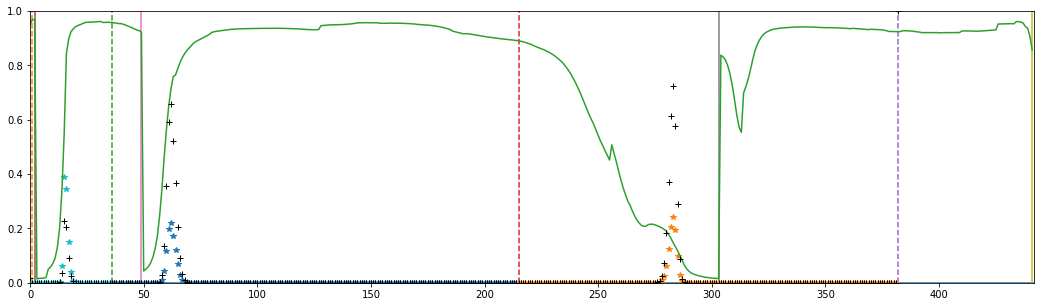

In [78]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid + ".txt"][i], 
                   loaded_vidid_selected_frames[cur_vidid + ".txt"][i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

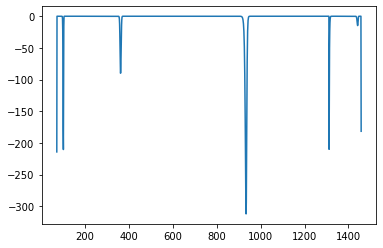

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

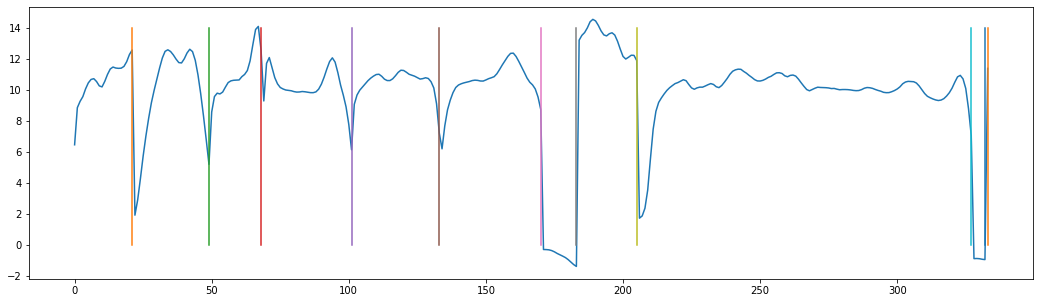

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss